This network is looking at the performance of aggregate NWs built from individual metacel networks

## Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scanpy as sc
import bottleneck
from scipy import stats, spatial
from scipy.ndimage import gaussian_filter
from scipy import io
import gc
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib import colors
import matplotlib_venn as venn
import seaborn as sns

import joypy
sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

from itertools import combinations
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

import networkx as nx
import dynamicTreeCut
import community
import gprofiler
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import sys
sys.path.append('../scripts/')
sys.path.append('/home/bharris/Correlation_Coexpression/scripts/')
sys.path.append('/home/bharris/vshape/scripts/')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from rank import rank
from processify import processify
from egad import run_egad
from egad_by_gene import run_egad_gene_score

import biccn_nw_perf_funcs as perf
import load_pearson_networks
import enrichment_stats as enrich

ModuleNotFoundError: No module named 'biccn_nw_perf_funcs'

## Functions

In [61]:
def contains_number(string):
    return re.search('\d', string)


def fix_marker_name(name):
    split_name = name.split('.')
    if name == 'Non.Neuronal':
        return name
    if len(split_name) == 1:
        return name
    if len(split_name) == 2:

        return '_'.join(split_name)
    if len(split_name) == 3:
        if contains_number(split_name[1]):
            return f'{split_name[0]}.{split_name[1]}_{split_name[2]}'
        else:
            return '_'.join(split_name)


fix_marker_name = np.vectorize(fix_marker_name)

In [3550]:
def create_term_nw(term_vector, nw, color, threshold=.9):
    selected_term_genes = np.intersect1d(genes,term_vector.index[term_vector.astype(bool)])
    adj = nw.loc[selected_term_genes,selected_term_genes]>=threshold
    #adj = adj.loc[adj.sum()>1,adj.sum()>1]

    G  = nx.from_pandas_adjacency(adj)
    nx.draw_circular(G,node_color=color)

## Load Data

In [5]:
dataset_dict = perf.dataset_dict
genes = perf.genes

In [6]:
kegg_tidy = pd.read_csv('/home/bharris/reference_networks/kegg/kegg_all.csv',
                        index_col=0)

kegg_tidy.head()

,V1,V2,V3
1,mmu00010,11674,Aldoa
2,mmu00010,11676,Aldoc
3,mmu00010,230163,Aldob
4,mmu00010,353204,Aldoart1
5,mmu00010,110695,Aldh7a1


In [7]:
kegg_tidy.set_index('V3', inplace=True)

kegg_genes = np.unique(kegg_tidy.index.values)

kegg_terms = np.unique(kegg_tidy.V1.values)

kegg = pd.DataFrame(0, index=kegg_genes, columns=kegg_terms)
for i, j in kegg_tidy[['V1']].groupby('V1').groups.items():
    kegg.at[j, i] = 1

In [3322]:
kegg_term_dict = pd.read_csv('/home/bharris/reference_networks/kegg/term2def.csv',index_col=1)['V1.1']

In [2858]:
kegg.to_csv('/home/bharris/biccn_paper/data/kegg_nw.csv')

In [352]:
all_metadata_color = pd.read_csv(
    '/home/bharris/biccn_paper/data/biccn_mouse_full_labels_new.csv',
    index_col=0)
class_label_palette = all_metadata_color[[
    'class_label', 'class_color'
]].groupby(['class_label', 'class_color']).size().reset_index().sort_values(
    ['class_label', 0], ascending=False).drop_duplicates(
        subset='class_label').set_index('class_label')['class_color']
replace_hyphen = np.vectorize(lambda x: x.replace('-', '.'))
class_label_palette.index = replace_hyphen(class_label_palette.index)

subclass_colors = pd.read_csv(
    '/home/bharris/biccn_paper/data/subclass_colors.csv', index_col=1,header=None)[0]
replace_space = np.vectorize(lambda x: x.replace(' ', '.'))
replace_slash = np.vectorize(lambda x: x.replace('/', '.'))
subclass_colors.index = fix_marker_name(replace_slash(replace_space(subclass_colors.index)))


combined_color_pal = pd.concat([subclass_colors,class_label_palette])

### Load in Networks

In [8]:
metacell_nws = {}
metacells_path = '/home/bharris/biccn_paper/data/networks/metacells/'
agg_all = np.zeros([genes.shape[0],genes.shape[0]])
for dataset in dataset_dict:
    logging.info(dataset)
    metacell_nws[dataset] = pd.read_hdf(f'{metacells_path}/metacell_agg_nw_{dataset}.hdf5','nw')
    agg_all+=metacell_nws[dataset].values
metacell_nws['aggregate'] = pd.DataFrame(rank(agg_all),index=genes,columns=genes)

2020-01-12 12:20:00,843 - zeng_10x_cell
2020-01-12 12:20:00,923 - zeng_10x_nuc
2020-01-12 12:20:00,988 - zeng_smart_cell
2020-01-12 12:20:01,046 - zeng_smart_nuc
2020-01-12 12:20:01,102 - zeng_10x_cell_v3
2020-01-12 12:20:01,156 - zeng_10x_nuc_v3
2020-01-12 12:20:01,212 - macosko_10x_nuc_v3


In [3762]:
del pearson_nws
gc.collect()

27316

In [3763]:
pearson_nws = load_pearson_networks.load_all_networks()

2020-03-16 02:47:32,385 - zeng_10x_cell
2020-03-16 02:48:06,598 - zeng_10x_nuc
2020-03-16 02:48:45,237 - zeng_smart_cell
2020-03-16 02:49:28,054 - zeng_smart_nuc
2020-03-16 02:49:58,180 - zeng_10x_cell_v3
2020-03-16 02:50:30,438 - zeng_10x_nuc_v3
2020-03-16 02:51:04,046 - macosko_10x_nuc_v3


## Heatmaps for Figure 2

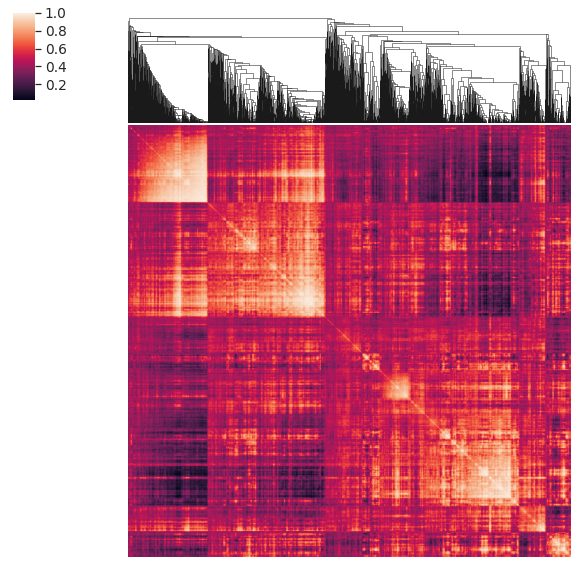

In [3665]:
metacell_nws['aggregate'].index.name='Genes'
metacell_nws['aggregate'].columns.name='Genes'
L = compute_nw_linkage(metacell_nws['aggregate'],method='average',metric='correlation')
gene_order = genes[hierarchy.leaves_list(L)]
filtered = pd.DataFrame(gaussian_filter(metacell_nws['aggregate'].loc[gene_order,
                                                         gene_order].values,
                           5),index=gene_order, columns=gene_order)
filtered = filtered.loc[genes,genes]

pd.Series(hierarchy.fcluster(L
                             ,
                             10,
                             criterion='maxclust'),
          index=genes).to_csv('/home/bharris/biccn_paper/data/metacell_cluster_assignments.csv')

g=sns.clustermap(filtered, 
               col_linkage=L, 
               row_linkage=L, rasterized=True)
g.ax_heatmap.set(xticks=[],yticks=[])
g.ax_row_dendrogram.set_visible(False)
plt.savefig('/home/bharris/biccn_paper/figures/metacells_heatmap.pdf',transparent=True)

In [2069]:
agg_brain_nw = np.zeros([genes.shape[0], genes.shape[0]])
datasets_used = []
bulk_datasets = np.genfromtxt('/home/bharris/biccn_paper/data/bulk_rna/datasets_used.csv',dtype=str)
for dataset in bulk_datasets:
    nw = pd.read_hdf(
        f'/home/bharris/biccn_paper/data/bulk_rna/networks/{dataset}_pearson_nw.hdf5',
        'nw')

    if np.all(np.isnan(nw.values)):
        logging.info(f'{dataset} is all nans')
        continue
    agg_brain_nw += nw.values
    del nw
    datasets_used.append(dataset)
    gc.collect()
agg_brain_nw = pd.DataFrame(rank(agg_brain_nw), index=genes, columns=genes)

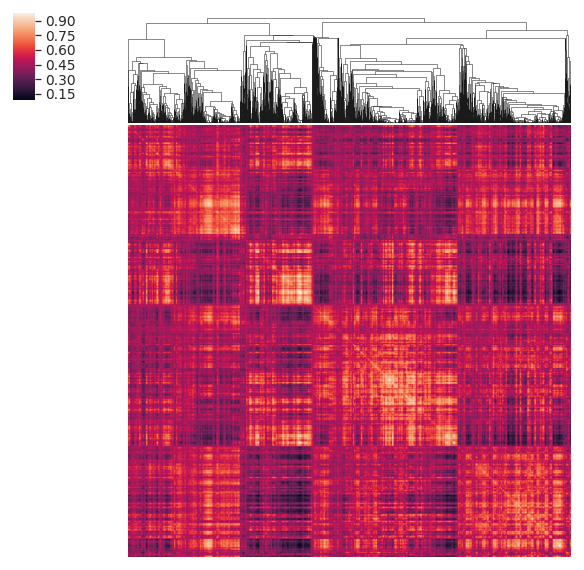

In [3664]:
agg_brain_nw.index.name='Genes'
agg_brain_nw.columns.name='Genes'
L = compute_nw_linkage(agg_brain_nw,method='average',metric='correlation')
metacell_cluster_dict = dict(zip(range(1,11),sns.color_palette('Set3',10)))

metacell_color = np.vectorize(lambda x: metacell_cluster_dict[x])

r,g,b = metacell_color(hierarchy.fcluster(L,n_clus,criterion='maxclust'))
gene_order = genes[hierarchy.leaves_list(L)]
filtered = pd.DataFrame(gaussian_filter(metacell_nws['aggregate'].loc[gene_order,
                                                         gene_order].values,
                           5),index=gene_order, columns=gene_order)
filtered = filtered.loc[genes,genes]

pd.Series(hierarchy.fcluster(L
                             ,
                             10,
                             criterion='maxclust'),
          index=genes).to_csv('/home/bharris/biccn_paper/data/bulk_cluster_assignments.csv')

g=sns.clustermap(filtered, 
               col_linkage=L, 
               row_linkage=L, rasterized=True)
g.ax_row_dendrogram.set_visible(False)
g.ax_heatmap.set(xticks=[],yticks=[])
plt.savefig('/home/bharris/biccn_paper/figures/bulk_heatmap.pdf',transparent=True)

## GO and KEGG performance Figures

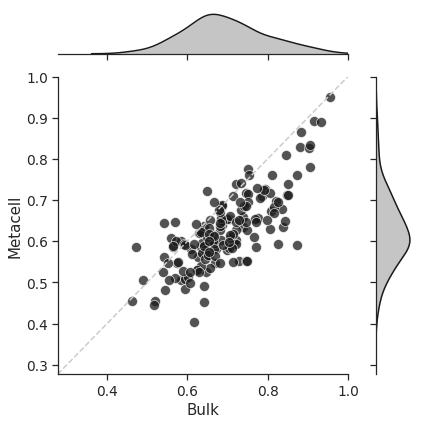

In [2604]:
bulk_metacell_kegg = pd.concat([run_egad(kegg,agg_brain_nw).AUC,run_egad(kegg,metacell_nws['aggregate']).AUC], axis=1)
bulk_metacell_kegg.columns =['Bulk','Metacell']

g = sns.jointplot(data=bulk_metacell_kegg,
                  x='Bulk',
                  y='Metacell',
                  color='k',
                  kind='kde')
xlim = g.ax_joint.get_xlim()
ylim = g.ax_joint.get_ylim()
g.ax_joint.cla()

sns.scatterplot(data=bulk_metacell_kegg,
                x='Bulk',
                y='Metacell',
                legend=False,
                s=100,
                alpha=.75,
                ax=g.ax_joint,
                color='k')
xlim = [min([xlim[0], ylim[0]]), min([1, max([xlim[1], ylim[1]])])]
g.ax_joint.set(xlim=xlim, ylim=xlim)
g.ax_joint.plot(xlim, xlim, c='.8', ls='--')
plt.tight_layout()

plt.savefig('/home/bharris/biccn_paper/figures/bulk_metacell_kegg_perf.pdf',transparent=True)

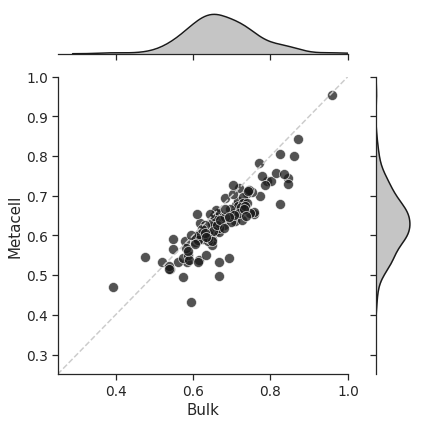

In [2605]:
bulk_metacell_go = pd.concat([run_egad(go_mouse_slim,agg_brain_nw).AUC,run_egad(go_mouse_slim,metacell_nws['aggregate']).AUC], axis=1)
bulk_metacell_go.columns =['Bulk','Metacell']

g = sns.jointplot(data=bulk_metacell_go,
                  x='Bulk',
                  y='Metacell',
                  color='k',
                  kind='kde')
xlim = g.ax_joint.get_xlim()
ylim = g.ax_joint.get_ylim()
g.ax_joint.cla()

sns.scatterplot(data=bulk_metacell_go,
                x='Bulk',
                y='Metacell',
                legend=False,
                s=100,
                alpha=.75,
                ax=g.ax_joint,
                color='k')
xlim = [min([xlim[0], ylim[0]]), min([1, max([xlim[1], ylim[1]])])]
g.ax_joint.set(xlim=xlim, ylim=xlim)
g.ax_joint.plot(xlim, xlim, c='.8', ls='--')
plt.tight_layout()

plt.savefig('/home/bharris/biccn_paper/figures/bulk_metacell_GO_perf.pdf',transparent=True)

In [ ]:
create_term_nw(kegg.loc[genes,kegg_perf_combined.index[-1]].fillna(0), metacell_nws['aggregate'],'g', threshold=.95)
plt.show()
create_term_nw(kegg.loc[genes,kegg_perf_combined.index[-1]].fillna(0), agg_brain_nw,'g', threshold=.95)

In [ ]:
create_term_nw(kegg.loc[genes,kegg_perf_combined.index[0]].fillna(0), metacell_nws['aggregate'],'b', threshold=.95)
plt.show()
create_term_nw(kegg.loc[genes,kegg_perf_combined.index[0]].fillna(0), agg_brain_nw,'b', threshold=.95)

In [ ]:
create_term_nw(go_mouse_slim.loc[genes,go_perf_combined.index[-1]].fillna(0), metacell_nws['aggregate'],'g', threshold=.95)
plt.show()
create_term_nw(go_mouse_slim.loc[genes,go_perf_combined.index[-1]].fillna(0), agg_brain_nw,'g', threshold=.95)

In [ ]:
create_term_nw(go_mouse_slim.loc[genes,go_perf_combined.index[0]].fillna(0), metacell_nws['aggregate'],'b', threshold=.95)
plt.show()
create_term_nw(go_mouse_slim.loc[genes,go_perf_combined.index[0]].fillna(0), agg_brain_nw,'b', threshold=.95)

## Build Metacells NWs with unique subclass metacells only

Here we compute Figure 3B and 3C

In [2383]:
agg_metacells_unique_subclass = np.zeros([genes.shape[0],genes.shape[0]])
unique_subclass_networks = {}
for dataset in dataset_dict:
    logging.info(dataset)
    nw = pd.read_hdf(f'/home/bharris/biccn_paper/data/networks/metacells/metacell_agg_nw_{dataset}_subclass_unique.hdf5','nw')
    unique_subclass_networks[dataset] = nw
    agg_metacells_unique_subclass+=nw.values
    del nw
    gc.collect()
    

agg_metacells_unique_subclass = pd.DataFrame(rank(agg_metacells_unique_subclass),index=genes,columns=genes)

2020-02-04 11:29:31,473 - zeng_10x_cell
2020-02-04 11:29:35,022 - zeng_10x_nuc
2020-02-04 11:29:38,381 - zeng_smart_cell
2020-02-04 11:29:41,613 - zeng_smart_nuc
2020-02-04 11:29:44,679 - zeng_10x_cell_v3
2020-02-04 11:29:47,725 - zeng_10x_nuc_v3
2020-02-04 11:29:50,741 - macosko_10x_nuc_v3


In [2385]:
def combined_dataset_nws(nw_dict, ds):
    agg = np.zeros([genes.shape[0],genes.shape[0]])
    for dataset in ds:
        agg+=nw_dict[dataset].values
    return pd.DataFrame(rank(agg),index=genes,columns=genes)

In [2386]:
nw_combinations = list(combinations(all_datasets, 4))
equal_subclass_markers_perf = []
for nw_ds in nw_combinations:

    marker_ds = all_datasets[~np.in1d(all_datasets, nw_ds)]
    markers_names = '_'.join(marker_ds)
    markers_nw = pd.read_csv(f'~/biccn_paper/data/markers_3ds/markers_{markers_names}.csv',index_col=0)
    iteration_name = '_'.join(nw_ds)
    logging.info(iteration_name)
    agg_nw = combined_dataset_nws(unique_subclass_networks, nw_ds)
    egad_res = perf.add_attributes(run_egad(markers_nw, agg_nw),
                                   'equal_markers', iteration_name)

    equal_subclass_markers_perf.append(
        pd.melt(egad_res.reset_index(),
                id_vars=['labels', 'metric', 'name'],
                var_name='EGAD_res'))
    del agg_nw, markers_nw

    del egad_res
    gc.collect()
equal_subclass_markers_perf = pd.concat(equal_subclass_markers_perf)

2020-02-04 11:35:18,625 - zeng_10x_cell_zeng_10x_nuc_zeng_smart_cell_zeng_smart_nuc
2020-02-04 11:35:29,588 - zeng_10x_cell_zeng_10x_nuc_zeng_smart_cell_zeng_10x_cell_v3
2020-02-04 11:35:38,464 - zeng_10x_cell_zeng_10x_nuc_zeng_smart_cell_zeng_10x_nuc_v3
2020-02-04 11:35:47,660 - zeng_10x_cell_zeng_10x_nuc_zeng_smart_cell_macosko_10x_nuc_v3
2020-02-04 11:35:56,568 - zeng_10x_cell_zeng_10x_nuc_zeng_smart_nuc_zeng_10x_cell_v3
2020-02-04 11:36:05,617 - zeng_10x_cell_zeng_10x_nuc_zeng_smart_nuc_zeng_10x_nuc_v3
2020-02-04 11:36:14,639 - zeng_10x_cell_zeng_10x_nuc_zeng_smart_nuc_macosko_10x_nuc_v3
2020-02-04 11:36:23,495 - zeng_10x_cell_zeng_10x_nuc_zeng_10x_cell_v3_zeng_10x_nuc_v3
2020-02-04 11:36:32,377 - zeng_10x_cell_zeng_10x_nuc_zeng_10x_cell_v3_macosko_10x_nuc_v3
2020-02-04 11:36:40,788 - zeng_10x_cell_zeng_10x_nuc_zeng_10x_nuc_v3_macosko_10x_nuc_v3
2020-02-04 11:36:49,630 - zeng_10x_cell_zeng_smart_cell_zeng_smart_nuc_zeng_10x_cell_v3
2020-02-04 11:36:58,502 - zeng_10x_cell_zeng_smart

In [2408]:
all_subclasses = equal_subclass_markers_perf.labels.unique()
all_subclasses = all_subclasses[~np.in1d(all_subclasses,['GABAergic','Glutamatergic','Non.Neuronal'])]

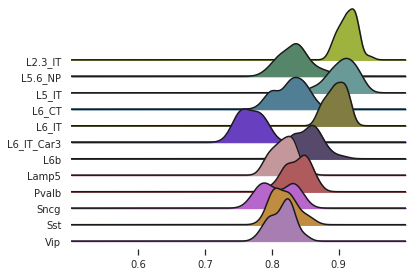

In [3781]:
temp = equal_subclass_markers_perf.loc[equal_subclass_markers_perf.labels.isin(all_subclasses) & 
                                   (equal_subclass_markers_perf.EGAD_res=='AUC'),['labels','value']]
a=temp.labels.value_counts()>1
temp = temp[temp.labels.isin(a[a].index)]
cmap = []
for row in np.sort(temp.labels.unique()):
    cmap.append(sns.desaturate(colors.to_rgba(subclass_colors[row]),.5))
subclass_cm = colors.ListedColormap(cmap)
joypy.joyplot(temp,by='labels', colormap=subclass_cm,x_range=[.5,1])
plt.savefig('/home/bharris/biccn_paper/figures/metacells_iterative_unqiue_subclass_markers_joyplot.pdf',transparent=True)

In [12]:
bulk_marker_boot = pd.read_csv('/home/bharris/biccn_paper/data/bulk_rna/bootstrap_100_markers.csv',index_col=0)

bulk_marker_boot = bulk_marker_boot.reset_index().groupby('index').mean()['AUC']

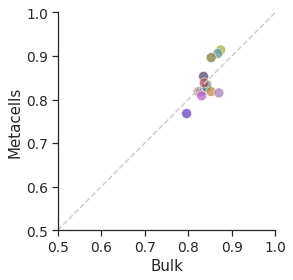

In [3784]:
ax = sns.scatterplot(bulk_marker_boot, 
                     equal_marker_avg,
                     hue=bulk_marker_boot.index,
                     palette=dict(zip(bulk_marker_boot.index,sns.color_palette(subclass_colors[bulk_marker_boot.index],                                                                
                                               desat=.5))),
                    s=100,
                    alpha=.75)
ax.set(aspect='equal',xlim=[.5,1],ylim=[.5,1])
ax.legend().set_visible(False)
ax.plot(ax.get_ylim(),ax.get_ylim(),ls='--',c='.8')
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/bulk_metacell_marker_perf.pdf',transparent=True)